In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorbayes.layers import Constant, Placeholder, Dense, GaussianSample
from tensorbayes.distributions import log_bernoulli_with_logits, log_normal
from tensorbayes.tbutils import cross_entropy_with_logits
from tensorbayes.nbutils import show_graph
from tensorbayes.utils import progbar
import numpy as np
import sys

# Data generation and multi-layer VAE subgraphs

In [2]:
activate = tf.nn.elu # choice of activation function
eps = 1e-8           # epsilon noise to prevent nan
def generate_one_bit_data(ndims):
    """Generates the data whose entropy is one.
    """
    x = np.array([np.zeros((ndims,)), np.ones((ndims,))])
    x = x.reshape(-1, ndims)
    x = np.tile(x, (500, 1))
    return x

def layer(x, size, scope, activation=None):
    with tf.variable_scope(scope):
        h = Dense(x, size, scope='dense')
        if activation is not None: h = activation(h)
        return h
    
def name(b_idx, z_idx, suffix):
    return 'z{:d}'.format(z_idx) + '_' + suffix

def encode_block(x, h_size, z_size, idx):
    """Encoding block. Takes lower stochastic layer x and encodes 
    into higher stochastic layer z. Computes posterior of higher 
    stochastic layer and samples from it.
    """
    with tf.variable_scope(name(idx, idx, 'encode')):
        h = layer(x, h_size, 'layer1', activation=activate)
        h = layer(h, h_size, 'layer2', activation=activate)
        h = layer(h, h_size, 'layer3', activation=activate)
    with tf.variable_scope(name(idx, idx, 'encode/posterior')):
        z_m = layer(h, z_size, 'mean')
        z_v = layer(h, z_size, 'variance', activation=tf.nn.softplus) + eps
    with tf.variable_scope(name(idx, idx, 'sample')):
        z = tf.reshape(GaussianSample(z_m, z_v, 'z'), (-1, 1))
    return z, (z_m, z_v)

def decode_block(z, h_size, x_size, idx):
    """Decoding block. Takes higher stochastic layer z and decodes 
    into the prior distribution of lower stochastic layer x.
    """
    with tf.variable_scope(name(idx, idx - 1, 'decode')):
        h = layer(z, h_size, 'layer1', activation=activate)
        h = layer(h, h_size, 'layer2', activation=activate)
        h = layer(h, h_size, 'layer3', activation=activate)
    with tf.variable_scope(name(idx, idx - 1, 'decode/prior')):
        if (idx - 1) == 0:
            logits = layer(h, x_size, 'logits')
            return logits
        else:
            x_m = layer(h, x_size, 'mean')
            x_v = layer(h, x_size, 'variance', activation=tf.nn.softplus) + eps
            x_prior = (x_m, x_v)
            return x_prior

# 1-layer VAE

In [13]:
def run_vae(ndims):
    print "Running 1-layer VAE with {:d} dims".format(ndims)
    data = generate_one_bit_data(ndims)
    tf.reset_default_graph()
    # encode
    z0 = Placeholder((None, ndims), name='z0')
    z1, z1_post = encode_block(z0, 10, 1, idx=1)
    # decode
    z1_prior = (Constant(0), Constant(1))
    z0_logits = decode_block(z1, 10, ndims, idx=1)

    with tf.name_scope('loss'):
        with tf.name_scope('recon_z0'):
            recon = -tf.reduce_mean(log_bernoulli_with_logits(z0, z0_logits))
        with tf.name_scope('KL'):
            kl1   = tf.reduce_mean(-log_normal(z1, *z1_prior) + log_normal(z1, *z1_post))
        loss = recon + kl1
        recon_per_dim = recon/ndims

    lr = Placeholder(None, name='lr')
    train_step = tf.train.AdamOptimizer(lr).minimize(loss)
    sess = tf.Session()    
    sess.run(tf.initialize_all_variables())
    iterep = 1000
    epochs = 5
    lr = 5e-3
    decay = np.exp(np.log(1e-4/lr)/(iterep * epochs))
    for i in range(iterep * epochs):
        sess.run(train_step, feed_dict={'z0:0': data, 'lr:0': lr})
        progbar(i, iterep)
        lr *= decay
        if (i + 1) %  iterep == 0:
            row = sess.run([recon_per_dim, kl1, loss], feed_dict={'z0:0': data})
            row += [lr]
            print "z0 recon/dim: {:9.2e}. z1 kl: {:9.2e}. loss: {:9.2e}. learning rate: {:9.2e}".format(*tuple(row))
            lr *= decay
    return sess.run([z1, loss, recon_per_dim], feed_dict={'z0:0': np.tile(data, (10, 1))})

In [15]:
# history = {}
# history[1000] = run_vae(1000)
# history[100] = run_vae(100)
# history[10] = run_vae(10)
# history[5] = run_vae(5)
# history[1] = run_vae(1)

In [40]:
show_graph(tf.get_default_graph().as_graph_def())

In [3]:
def run_vae2(ndims):
    print "Running 2-layer VAE with {:d} dims".format(ndims)
    data = generate_one_bit_data(ndims)
    tf.reset_default_graph()
    # encode
    z0 = Placeholder((None, ndims), name='z0')
    z1, z1_post = encode_block(z0, 10, 1, idx=1)
    z2, z2_post = encode_block(z1, 100, 1, idx=2)
    # decode
    z2_prior = (Constant(0), Constant(1))
    z1_prior = decode_block(z2, 100, 1, idx=2)
    z0_logits = decode_block(z1, 10, ndims, idx=1)
    # evaluation purposes:
    z1_prior_sample = tf.reshape(GaussianSample(*z1_prior, scope='prior_samples/z1'), (-1, 1))
    
    with tf.name_scope('loss'):
        with tf.name_scope('recon_z0'):
            recon = -tf.reduce_mean(log_bernoulli_with_logits(z0, z0_logits))
        with tf.name_scope('recon_z1'):
            kl1   = tf.reduce_mean(-log_normal(z1, *z1_prior) + log_normal(z1, *z1_post))
        with tf.name_scope('KL'):
            kl2   = tf.reduce_mean(-log_normal(z2, *z2_prior) + log_normal(z2, *z2_post))
        loss = recon + kl1 + kl2
        recon_per_dim = recon/ndims

    lr = Placeholder(None, name='lr')
    train_step = tf.train.AdamOptimizer(lr).minimize(loss)
    sess = tf.Session()    
    sess.run(tf.initialize_all_variables())    
    iterep = 1000
    epochs = 5
    lr = 5e-3
    decay = np.exp(np.log(1e-4/lr)/(iterep * epochs))
    for i in range(iterep * epochs):
        sess.run(train_step, feed_dict={'z0:0': data, 'lr:0': lr})
        progbar(i, iterep)
        lr *= decay 
        if (i + 1) %  iterep == 0:
            row = sess.run([recon_per_dim, kl1, kl2, loss], feed_dict={'z0:0': data})
            row += [lr]
            print ("z0 recon/dim: {:9.2e}. z1 recon: {:9.2e}. z2 kl: {:9.2e}. loss: {:9.2e}. learning rate: {:9.2e}"
                   .format(*tuple(row)))
    return sess.run([z2, z1, z1_prior_sample, loss, recon_per_dim], feed_dict={'z0:0': np.tile(data, (10, 1))}) 

In [10]:
# history2 = {}
# Training is finnicky. Will have to reinitialize a few times to get good performance.
# Training difficulty is attributable to the challenging nature of making q(z2|x) approximate a truncated Gaussian
# history2[1000] = run_vae2(1000)
# history2[100] = run_vae2(100)
# history2[10] = run_vae2(10)
# history2[5] = run_vae2(5)
# history2[1] = run_vae2(1)

In [8]:
show_graph(tf.get_default_graph().as_graph_def())

# Visualization/Analysis of Top Stochastic Layer Encoding Distribution

In [1]:
%pylab inline
import seaborn as sns
from scipy.stats import norm as normal

Populating the interactive namespace from numpy and matplotlib


In [23]:
#np.save('history.npy', history) 
#np.save('history2.npy', history2) 
read_history = np.load('history.npy').item()
read_history2 = np.load('history2.npy').item()

In [4]:
colors = sns.color_palette("PuBu", 6)[1:]
keys = [1, 5, 10, 100, 1000]

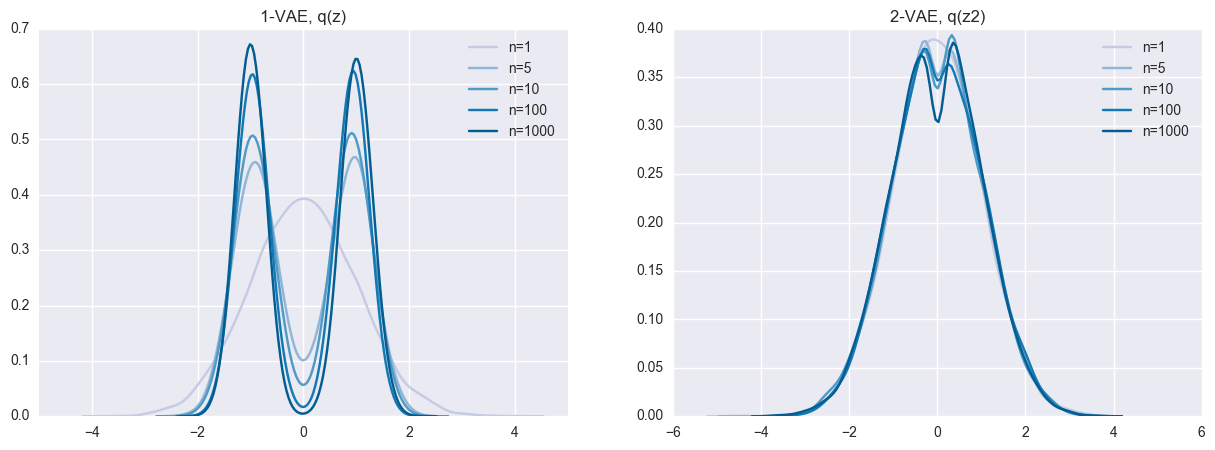

In [5]:
f, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].set_title('1-VAE, q(z)')
for i in xrange(len(keys)):
    sns.kdeplot(read_history[keys[i]][0].reshape(-1), color=colors[i], label='n={:d}'.format(keys[i]), ax=ax[0])   
ax[1].set_title('2-VAE, q(z2)')
for i in xrange(len(keys)):
    sns.kdeplot(read_history2[keys[i]][0].reshape(-1), color=colors[i], label='n={:d}'.format(keys[i]))
plt.savefig('images/encoding_over_time.png', dpi=200, bbox_inches='tight')

In [6]:
approx_z = np.random.randn(10000)

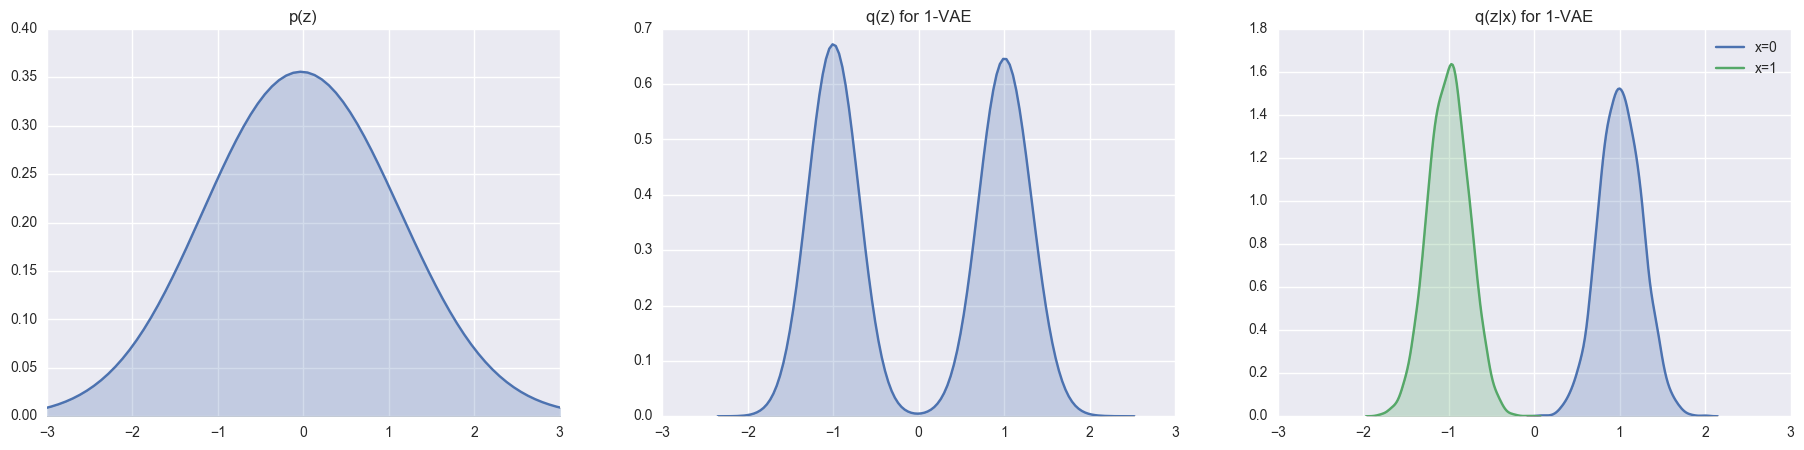

In [7]:
f, ax = plt.subplots(1, 3, figsize=(22.5, 5), sharex=True)
plt.xlim([-3, 3])
ax[0].set_title('p(z)')
ax[1].set_title('q(z) for 1-VAE')
ax[2].set_title('q(z|x) for 1-VAE')
ax[0].set_ylim([0, 0.4])
sns.kdeplot(approx_z, shade=True, ax=ax[0], bw=0.5)
sns.kdeplot(read_history[1000][0].reshape(-1), shade=True, ax=ax[1])
sns.kdeplot(read_history[1000][0][::2].reshape(-1), shade=True, ax=ax[2], label='x=0')
sns.kdeplot(read_history[1000][0][1::2].reshape(-1), shade=True, ax=ax[2], label='x=1')
plt.savefig('images/vae1_dim=1000.png', dpi=200, bbox_inches='tight')    

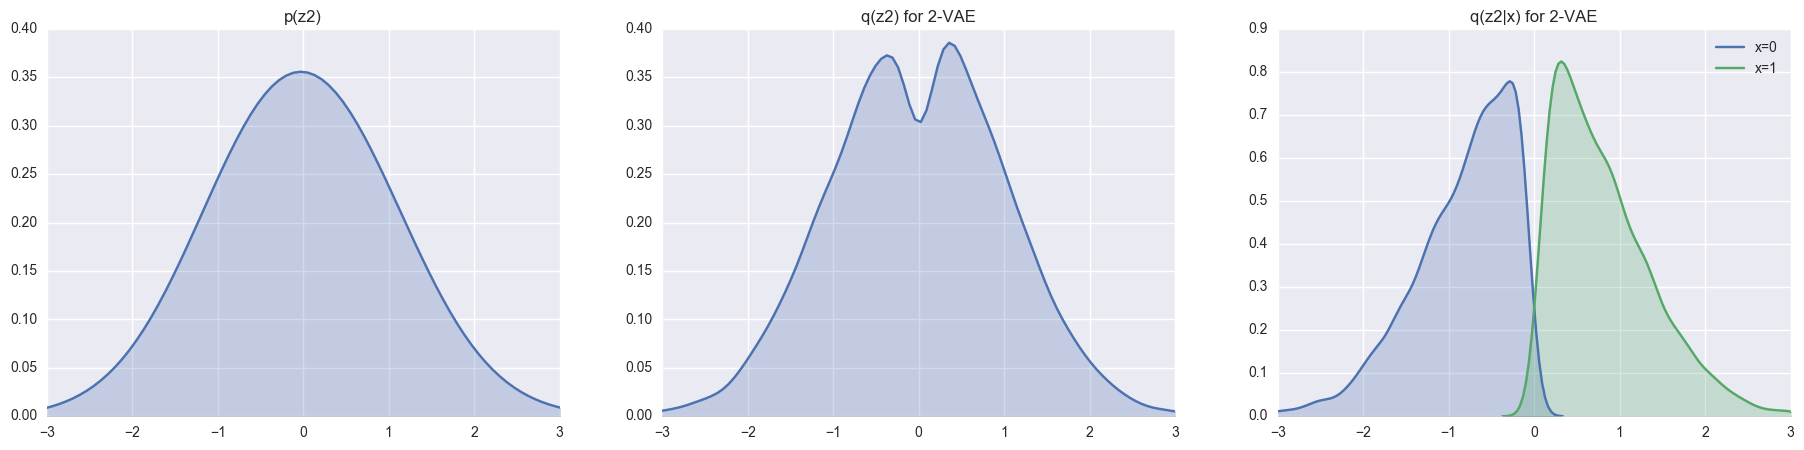

In [8]:
f, ax = plt.subplots(1, 3, figsize=(22.5, 5), sharex=True)
plt.xlim([-3, 3])
ax[0].set_title('p(z2)')
ax[1].set_title('q(z2) for 2-VAE')
ax[2].set_title('q(z2|x) for 2-VAE')
ax[0].set_ylim([0, 0.4])
sns.kdeplot(approx_z, shade=True, ax=ax[0], bw=0.5)
sns.kdeplot(read_history2[1000][0].reshape(-1), shade=True, ax=ax[1])
sns.kdeplot(read_history2[1000][0][::2].reshape(-1), shade=True, ax=ax[2], label='x=0')
sns.kdeplot(read_history2[1000][0][1::2].reshape(-1), shade=True, ax=ax[2], label='x=1')
plt.savefig('images/vae2_dim=1000.png', dpi=200, bbox_inches='tight')    

In [43]:
loss = [read_history[keys[i]][-2] for i in range(len(keys))]
loss2 = [read_history2[keys[i]][-2] for i in range(len(keys))]
recon_per_dim = [read_history[keys[i]][-1] for i in range(len(keys))]
recon_per_dim2 = [read_history2[keys[i]][-1] for i in range(len(keys))]

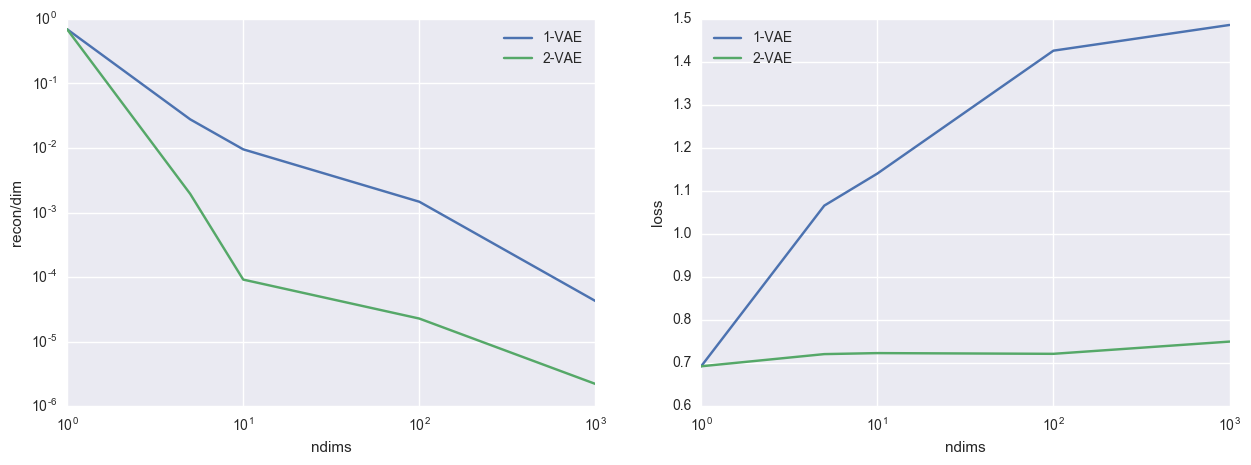

In [67]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].loglog()
ax[0].plot(keys, recon_per_dim, label='1-VAE')
ax[0].plot(keys, recon_per_dim2, label='2-VAE')
ax[0].set_xlabel('ndims')
ax[0].set_ylabel('recon/dim')
ax[0].legend()
ax[1].semilogx()
ax[1].plot(keys, loss, label='1-VAE')
ax[1].plot(keys, loss2, label='2-VAE')
ax[1].set_xlabel('ndims')
ax[1].set_ylabel('loss')
ax[1].legend(loc='upper left')
plt.savefig('images/rec_and_loss.png', dpi=200, bbox_inches='tight')    